# Analise de Débitos da Conta NY

In [1]:
# Carregando os Dados
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as scp
from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
import warnings
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.api import ExponentialSmoothing
warnings.filterwarnings('ignore')

## Carregando os Dados

In [2]:
df = pd.read_excel('Dados.xlsx', sheet_name='Planilha1')
df.head()

,Data,TOT DBTS (0)
0,2021-07-14,96560.49
1,2021-07-15,48410.98
2,2021-07-16,28180.73
3,2021-07-19,117518.49
4,2021-07-20,18046.76


In [3]:
df.Data.describe()

count                     243
unique                    243
top       2022-05-25 00:00:00
freq                        1
first     2021-07-14 00:00:00
last      2022-06-30 00:00:00
Name: Data, dtype: object

In [4]:
df.describe().round(2)

,TOT DBTS (0)
count,243.00
mean,48593.82
std,30463.29
min,3136.20
25%,30359.02
50%,38830.66
75%,54378.16
max,225701.71


In [5]:
# Trasnformando coluna em data
df['Data'] = pd.to_datetime(df['Data'])

## Analisando a série temporal de débitos

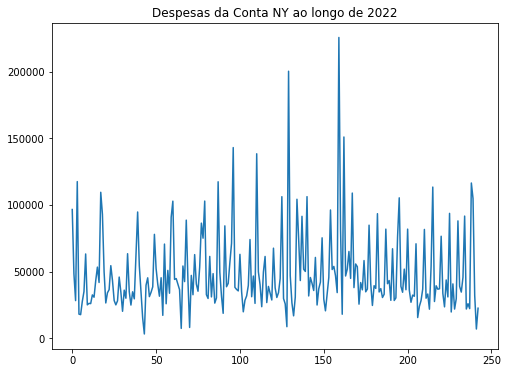

In [6]:
plt.figure(figsize = (8,6))
df['TOT DBTS (0)'].plot()
plt.title('Despesas da Conta NY ao longo de 2022')
plt.show()

### Tentando criar uma tendencia temporar de debitos na conta

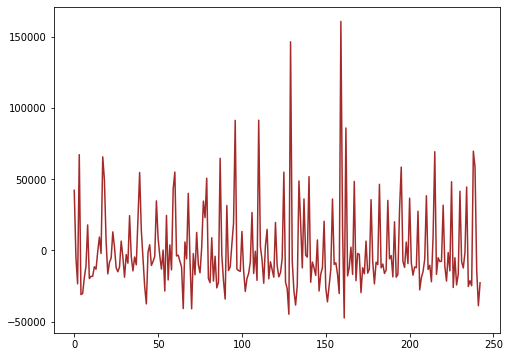

In [7]:
cycle, trend = hpfilter(df['TOT DBTS (0)'])
plt.figure(figsize = (8,6))
cycle.plot(color = 'brown')
plt.show()

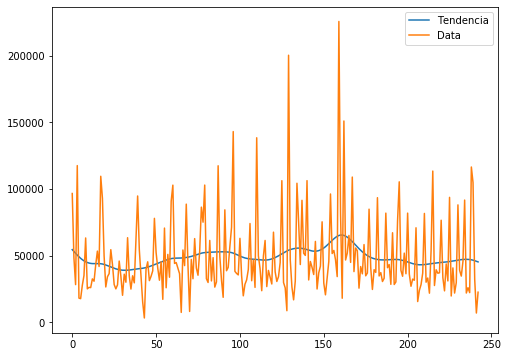

In [8]:
plt.figure(figsize = (8,6))
trend.plot(legend = True, label ='Tendencia')
df['TOT DBTS (0)'].plot(legend = True, label = 'Data')
plt.show()

Como existem alguns picos e poucos dados, a tendencia consegue acompanhar o desenho da curva mas não consegue explicar os dados

### Decompondo a série temporal

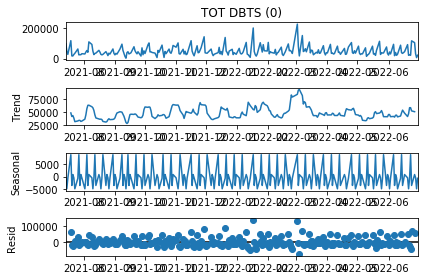

In [9]:
ts_log = df.set_index('Data')

result = seasonal_decompose(ts_log['TOT DBTS (0)'], model = 'add', period = 6)
result.plot();

# Aplicando Estatistica

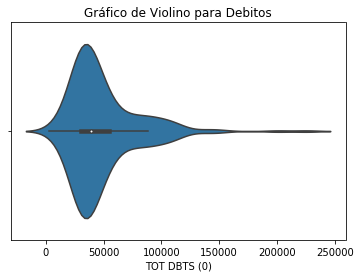

In [10]:
# Imprindo um gráfico de Violiono para ver a variação dos Dados
plt.title('Gráfico de Violino para Debitos')
sns.violinplot(x=df['TOT DBTS (0)'])
plt.show()

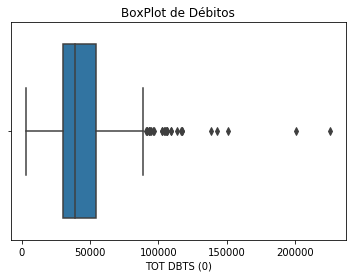

In [11]:
# Realizando o Boxplot dos Dados
plt.title('BoxPlot de Débitos')
sns.boxplot(x=df['TOT DBTS (0)'])
plt.show()

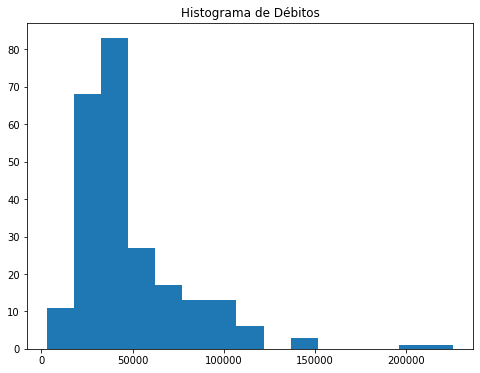

In [12]:
plt.figure(figsize = (8,6))
plt.title('Histograma de Débitos')
plt.hist(df['TOT DBTS (0)'], bins= 15)
plt.show()

In [13]:
# Resumo estatistico sobre os dados
scp.describe(df['TOT DBTS (0)'])

DescribeResult(nobs=243, minmax=(3136.2, 225701.71), mean=48593.82086987654, variance=928011833.6537507, skewness=2.1473698471768725, kurtosis=6.8604470153480985)

Com esse resumo podemos ver os Coeficientes de Assimetria é muito alto, isso indica que é uma distribuição altamente distribuida, dificultando a previsão

In [14]:
stat,p = scp.shapiro(df['TOT DBTS (0)'])
print("Resultado do teste de normalidade dos dados\np-value = %.3f"%(p))

Resultado do teste de normalidade dos dados
p-value = 0.000


Ou seja, nosso valor p é menor que 0,05, logo temos evidencias estatisticas para rejeitar que os dados seguem uma distribuição normal

## Tentando realizar previsões com os dados

In [15]:
modelo = ExponentialSmoothing(df['TOT DBTS (0)'],
                             trend = 'add').fit()

Text(0, 0.5, 'Débitos')

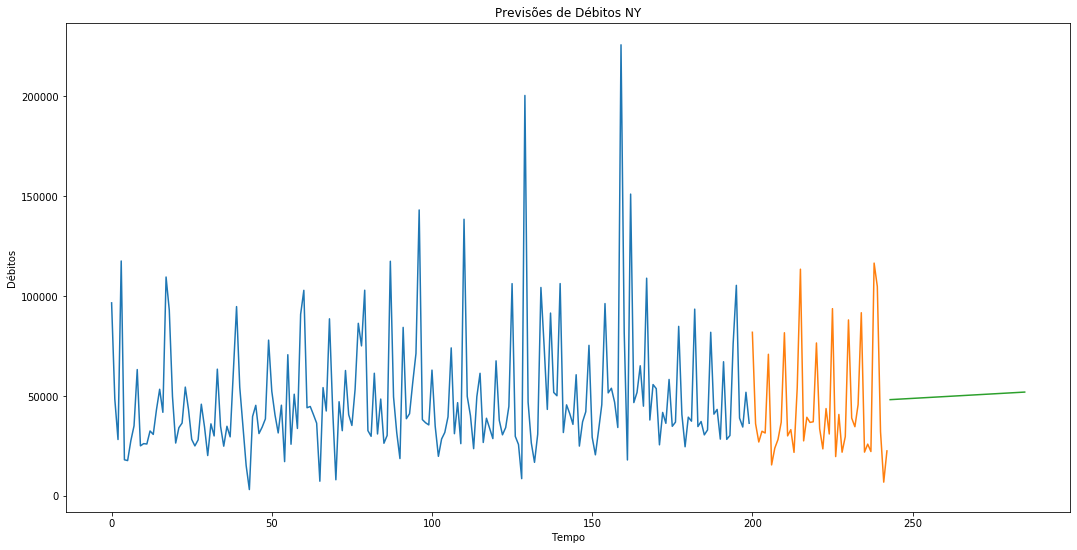

In [16]:
previsto = modelo.forecast(43)

plt.figure(figsize = (18,9))
plt.plot(df['TOT DBTS (0)'][:200], label = 'Dados de Treino')
plt.plot(df['TOT DBTS (0)'][200:], label = 'Dados de Teste')
plt.plot(previsto, label = 'Previsões')
plt.title('Previsões de Débitos NY')
plt.xlabel('Tempo')
plt.ylabel('Débitos')

In [17]:
# Calcula o erro
rms = np.sqrt(mean_squared_error(df['TOT DBTS (0)'][200:], previsto))
print("RMSE : ", rms)

RMSE :  28532.7518653671


# Tentativa 2

Retirando os outliers

In [18]:
# Carregando os Dados originais
df = pd.read_excel('Dados.xlsx', sheet_name='Planilha1')
df.describe()

,TOT DBTS (0)
count,243.000000
mean,48593.820870
std,30463.286652
min,3136.200000
25%,30359.020000
50%,38830.660000
75%,54378.165000
max,225701.710000


In [19]:
#Calculando o score Z
media = df['TOT DBTS (0)'].mean()
desvio = df['TOT DBTS (0)'].std()

df['Z'] = round(((df['TOT DBTS (0)'] - media) / desvio), 0)
df.head()

,Data,TOT DBTS (0),Z
0,2021-07-14,96560.49,2.0
1,2021-07-15,48410.98,-0.0
2,2021-07-16,28180.73,-1.0
3,2021-07-19,117518.49,2.0
4,2021-07-20,18046.76,-1.0


In [20]:
# Vizualizando quantos desvios padrões estão os dados
df['Z'].value_counts()

-0.0    112
-1.0     82
 1.0     28
 2.0     16
 3.0      3
 5.0      1
 6.0      1
Name: Z, dtype: int64

Vou optar por remover quem for Z < 2

In [21]:
# Realizando o filtro
df = df.loc[df.Z < 2]

# Removendo colunas de apoio
df = df.drop(columns=['Z'])

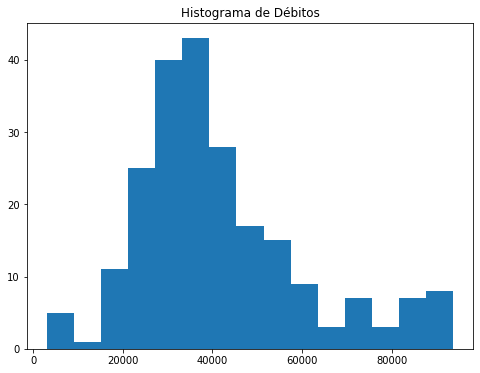

In [22]:
# Realizando histograma
plt.figure(figsize = (8,6))
plt.title('Histograma de Débitos')
plt.hist(df['TOT DBTS (0)'], bins= 15)
plt.show()

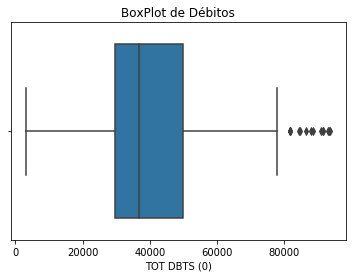

In [23]:
# Realizando o Boxplot dos Dados
plt.title('BoxPlot de Débitos')
sns.boxplot(x=df['TOT DBTS (0)'])
plt.show()

In [24]:
# Resumo estatistico sobre os dados
scp.describe(df['TOT DBTS (0)'])

DescribeResult(nobs=222, minmax=(3136.2, 93672.94000000002), mean=41651.64784405406, variance=351481808.28591645, skewness=0.9825432775584454, kurtosis=0.6524794669967395)

Com essa limpeza, consegui melhorar a assimetria dos dados. Porém ainda esta altamente instavel e tendendo a ser maior que a média

In [25]:
modelo = ExponentialSmoothing(df['TOT DBTS (0)'],
                             trend = 'add').fit()

Text(0, 0.5, 'Débitos')

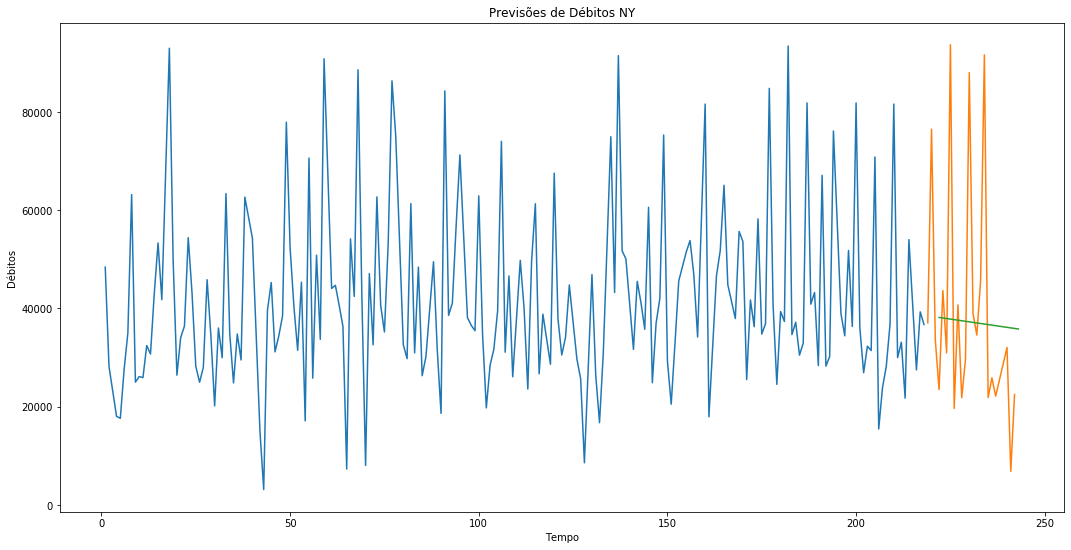

In [26]:
previsto = modelo.forecast(60)

previsto = modelo.forecast(22)

plt.figure(figsize = (18,9))
plt.plot(df['TOT DBTS (0)'][:200], label = 'Dados de Treino')
plt.plot(df['TOT DBTS (0)'][200:], label = 'Dados de Teste')
plt.plot(previsto, label = 'Previsões')
plt.title('Previsões de Débitos NY')
plt.xlabel('Tempo')
plt.ylabel('Débitos')

In [27]:
# Calcula o erro
rms = np.sqrt(mean_squared_error(df['TOT DBTS (0)'][200:], previsto))
print("RMSE : ", rms)

RMSE :  24167.064806114897


# Tentativa 3

In [28]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, acf, pacf
from sklearn.model_selection import train_test_split

In [29]:
# Carregando os Dados originais
df = pd.read_excel('Dados.xlsx', sheet_name='Planilha1')

In [30]:
# Calculando estatisticas moveis
ma = df['TOT DBTS (0)'].rolling(window = 3).mean()
std = df['TOT DBTS (0)'].rolling(window = 3).std()

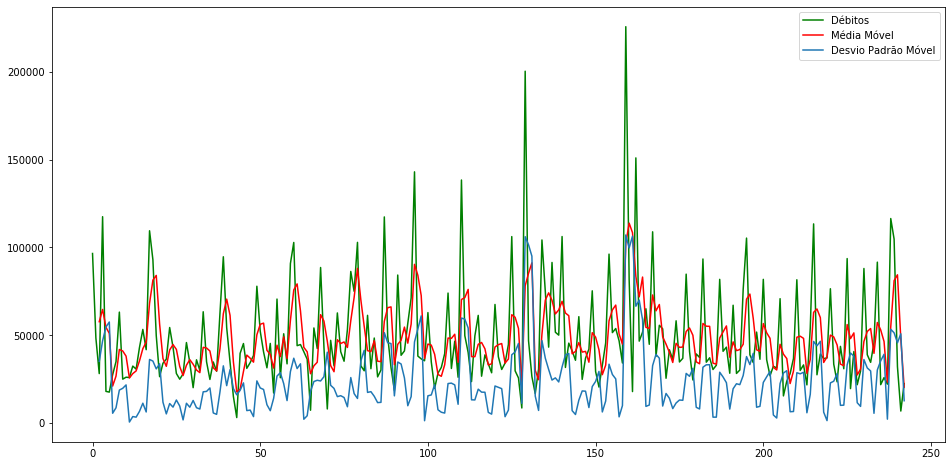

In [31]:
# Plot
plt.figure(figsize = (16,8))
df['TOT DBTS (0)'].plot(color = 'g', label = 'Débitos')
ma.plot(color = 'r', label = 'Média Móvel')
std.plot(label = 'Desvio Padrão Móvel')
plt.legend()
plt.show()

Text(0.5, 1.0, 'Retornos')

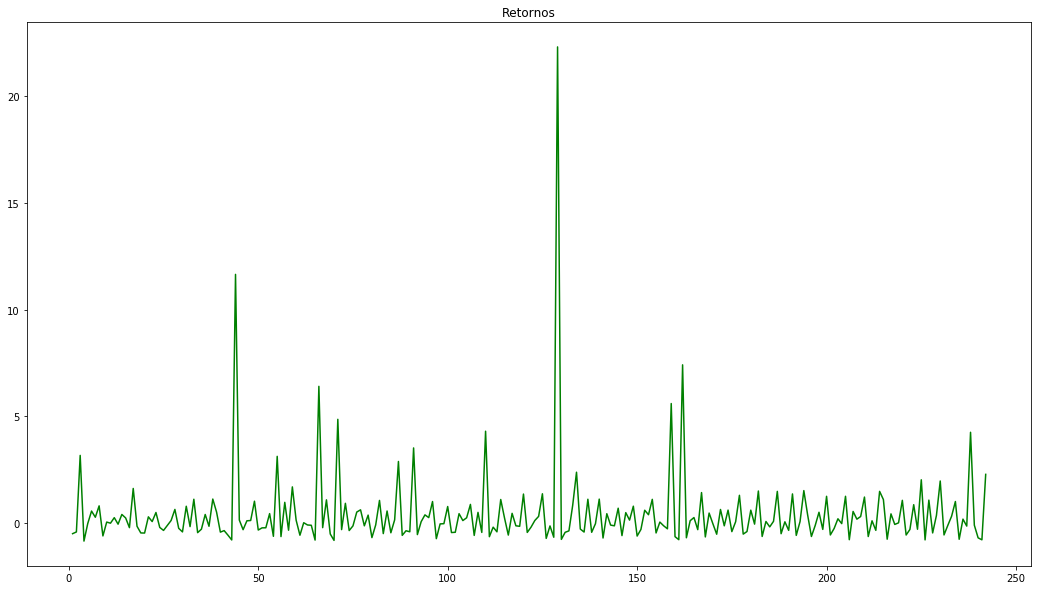

In [32]:
# Verificando a variação de um dia para o outro

# Calcula os retornos (ganhos)
retornos = (df['TOT DBTS (0)'] / df['TOT DBTS (0)'].shift(1) - 1)

# Plot
plt.figure(figsize = (18,10))
retornos.plot(label = 'Retorno', color = 'g')
plt.title("Retornos")

In [33]:
df.shape

(243, 2)

In [34]:
# Split em dados de treino e teste
dados_treino = df[:221]
dados_teste = df[221:]

In [35]:
dados_treino.shape

(221, 2)

In [36]:
dados_teste.shape

(22, 2)

## Testando a Estacionaridade

Uma série estacionária é o que em matemática costuma se chamar série convergente, ou seja, aquela que flutua em torno de uma mesma média ao longo do tempo.

Para criar um modelo de previsão de série temporal, precisamos validar a suposição de que a série é estacionária. Vamos criar uma função e testar em nossos dados.

In [37]:
# Função para estar a eatacionaridade
def testa_estacionaridade(timeseries):

    # Calcula as estatísticas móveis
    rolmean = timeseries.rolling(3).mean()
    rolstd = timeseries.rolling(3).std()

    # Plot das estatísticas móveis
    plt.figure(figsize = (18,9))
    plt.plot(timeseries, color = 'blue', label = 'Original')
    plt.plot(rolmean, color = 'r', label = 'Média Móvel')
    plt.plot(rolstd, color = 'black', label = 'Desvio Padrão Móvel')
    plt.xlabel('Data')
    plt.legend()
    plt.title('Estatísticas Móveis',  fontsize = 30)
    plt.show(block = False)
 
    print('Resultados do Teste Dickey Fuller:')
    result = adfuller(timeseries, autolag = 'AIC')
    labels = ['ADF Test Statistic', 'Valor-p', 'Número de Lags', 'Número de Observações']
    
    for value,label in zip(result, labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("Evidências fortes para rejeitar a hipótese nula (H0). Os dados são estacionários.")
    else:
        print("Evidência fraca contra hipótese nula. Série temporal não é estacionária.")

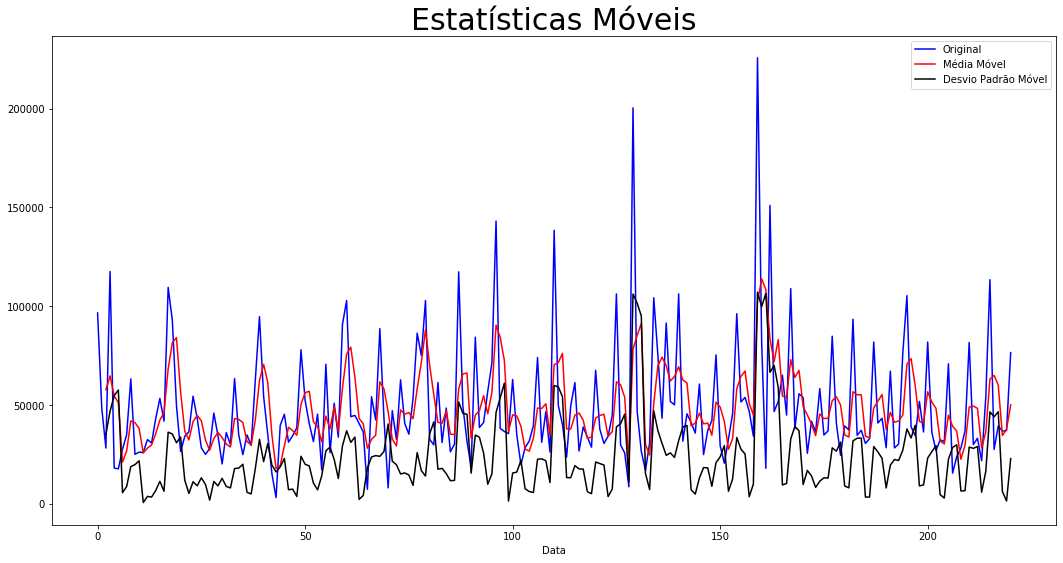

Resultados do Teste Dickey Fuller:
ADF Test Statistic : -5.225960927675084
Valor-p : 7.78017192773851e-06
Número de Lags : 4
Número de Observações : 216
Evidências fortes para rejeitar a hipótese nula (H0). Os dados são estacionários.


In [38]:
# Aplica a função
testa_estacionaridade(dados_treino['TOT DBTS (0)'])

In [39]:
# Aplica transformação de log
dados_treino_log = np.log(dados_treino['TOT DBTS (0)']) 
dados_teste_log = np.log(dados_teste['TOT DBTS (0)'])

In [40]:
# Média móvel
media_movel = dados_treino_log.rolling(3).mean() 

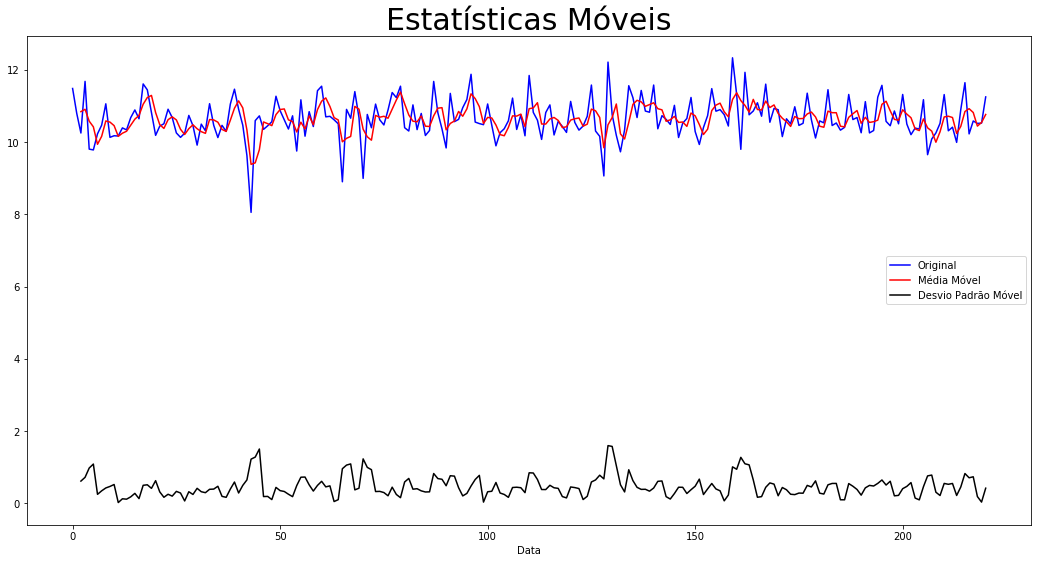

Resultados do Teste Dickey Fuller:
ADF Test Statistic : -5.831540851988738
Valor-p : 3.9644820465492797e-07
Número de Lags : 5
Número de Observações : 215
Evidências fortes para rejeitar a hipótese nula (H0). Os dados são estacionários.


In [41]:
# Aplica a função
testa_estacionaridade(dados_treino_log)

In [42]:
# Calcula a diferença entre log e media_movel
dados_treino_log_diff = dados_treino_log - media_movel
dados_treino_log_diff.dropna(inplace = True)

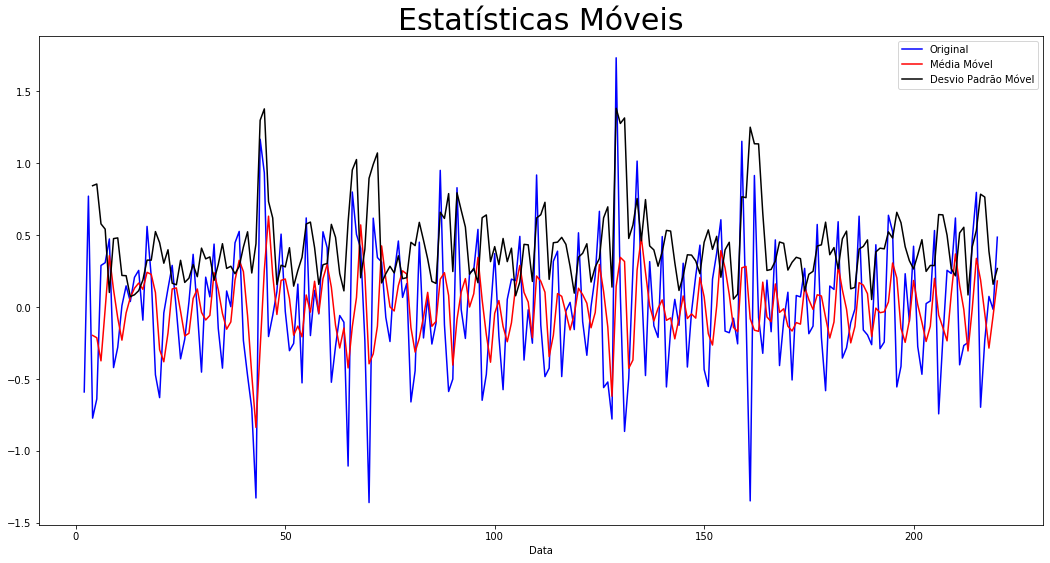

Resultados do Teste Dickey Fuller:
ADF Test Statistic : -6.3743269377786005
Valor-p : 2.303698959599856e-08
Número de Lags : 15
Número de Observações : 203
Evidências fortes para rejeitar a hipótese nula (H0). Os dados são estacionários.


In [43]:
# Aplcia a função
testa_estacionaridade(dados_treino_log_diff)

In [44]:
# Encontra o melhor modelo ARIMA, cria o modelo e faz as previsões
modelo = auto_arima(dados_treino_log, trace = True, error_action = 'ignore', suppress_warnings = True)
modelo.fit(dados_treino_log)
previsoes = modelo.predict(n_periods = len(dados_teste))
previsoes = pd.DataFrame(previsoes, index = dados_teste_log.index, columns = ['Prediction'])

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=371.360, Time=0.57 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=369.851, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=371.327, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=371.235, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1675.185, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=373.078, Time=0.09 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.824 seconds


Text(0, 0.5, 'Débitos')

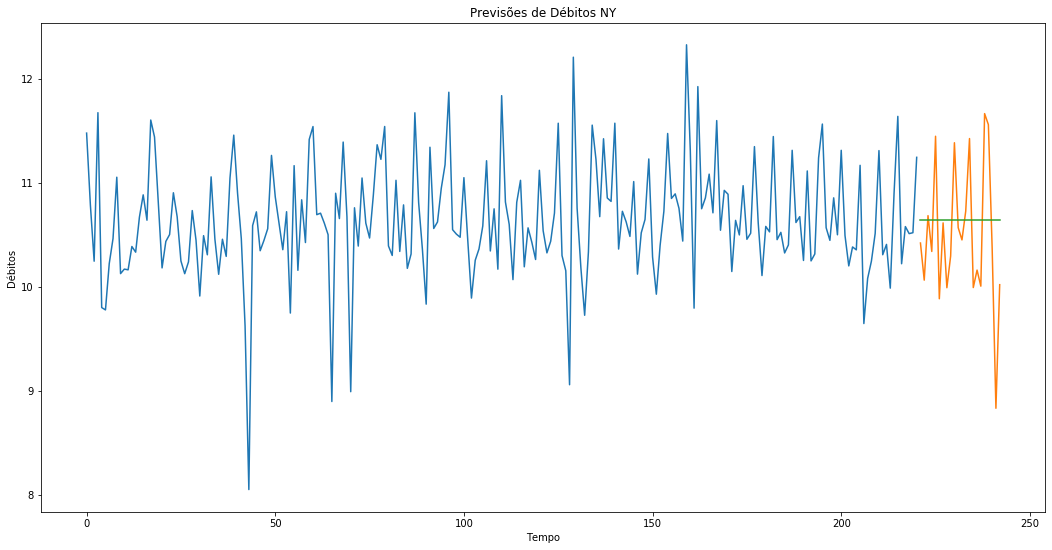

In [45]:
# Plot
plt.figure(figsize = (18,9))
plt.plot(dados_treino_log, label = 'Dados de Treino')
plt.plot(dados_teste_log, label = 'Dados de Teste')
plt.plot(previsoes, label = 'Previsões')
plt.title('Previsões de Débitos NY')
plt.xlabel('Tempo')
plt.ylabel('Débitos')

In [46]:
# Calcula o erro
rms = np.sqrt(mean_squared_error(dados_teste_log, previsoes))
print("RMSE : ", rms)

RMSE :  0.6795747501810071


In [47]:
# Modelo de série temporal
modelo_v1 = SARIMAX(dados_treino_log, order = (1, 1, 1), seasonal_order = (0, 0, 0, 0))

In [48]:
# Treinamento do modelo
resultado = modelo_v1.fit()

In [49]:
resultado.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           TOT DBTS (0)   No. Observations:                  221
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -184.875
Date:                Sun, 31 Jul 2022   AIC                            375.750
Time:                        13:28:00   BIC                            385.931
Sample:                             0   HQIC                           379.861
                                - 221                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0480      0.061      0.786      0.432      -0.072       0.168
ma.L1         -0.9885      0.019    -51.354      0.000      -1.026      -0.951
sigma2         0.3091      0.021     14.617      0.000       0.268       0.351
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                37.58
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               0.71   Skew:                            -0.18
Prob(H) (two-sided):                  0.14   Kurtosis:                         4.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

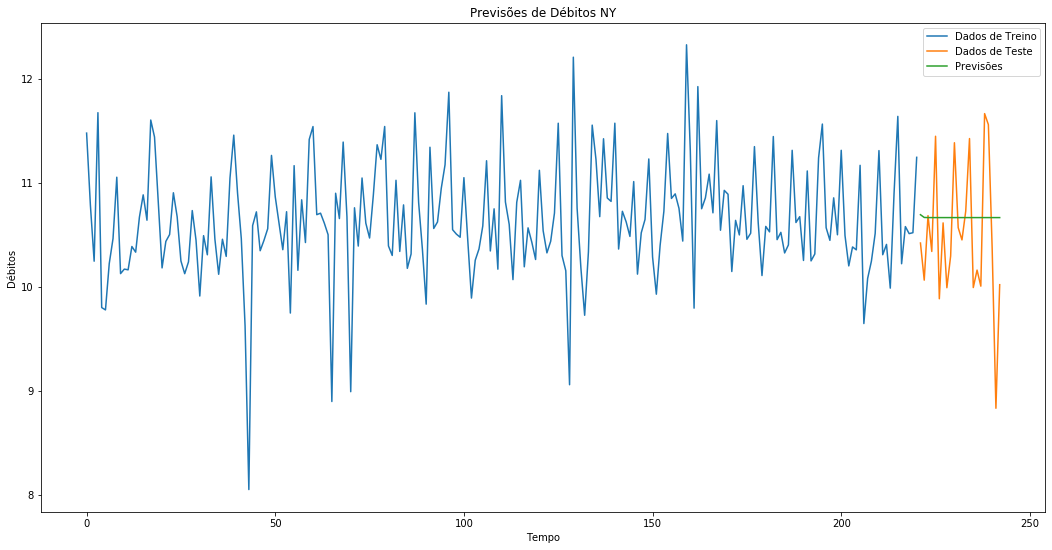

In [50]:
# Vamos fazer a previsão dos próximos 10 dias
forecast = resultado.forecast(22)

# Plot
plt.figure(figsize = (18,9))
plt.plot(dados_treino_log, label = 'Dados de Treino')
plt.plot(dados_teste_log, label = 'Dados de Teste')
plt.plot(forecast, label = 'Previsões')
plt.title('Previsões de Débitos NY')
plt.xlabel('Tempo')
plt.ylabel('Débitos')
plt.legend()

In [51]:
# Calcula o erro
rms = np.sqrt(mean_squared_error(dados_teste_log, forecast))
print("RMSE : ", rms)

RMSE :  0.6846653757233283


In [52]:
# Modelo de série temporal
modelo_v2 = SARIMAX(dados_treino['TOT DBTS (0)'], order = (1, 1, 1), seasonal_order = (0, 0, 0, 0))

# Treinamento do modelo
resultado = modelo_v2.fit()
# Vamos fazer a previsão dos próximos 10 dias
forecast = resultado.forecast(22)

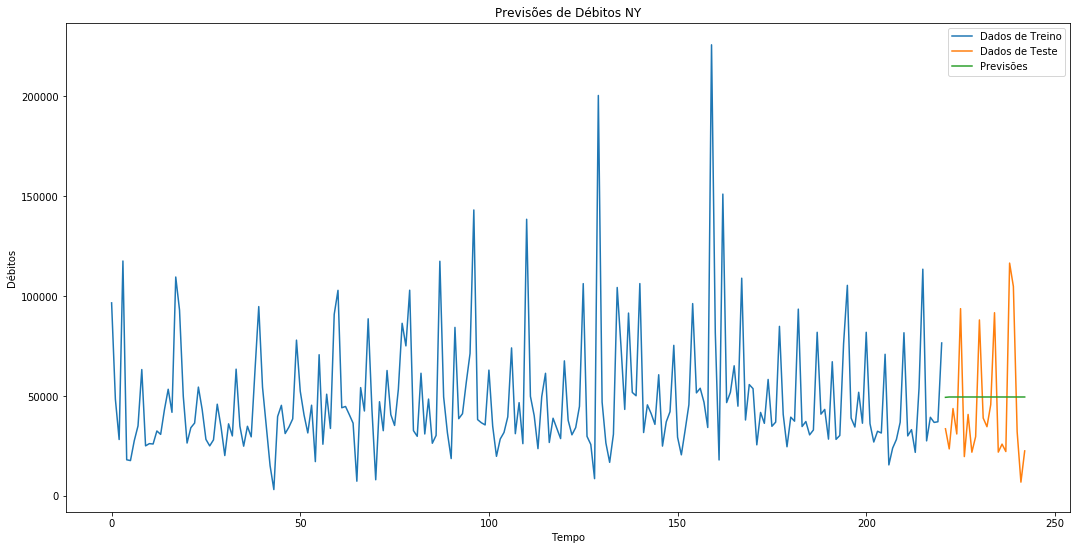

In [53]:
# Plot
plt.figure(figsize = (18,9))
plt.plot(dados_treino['TOT DBTS (0)'], label = 'Dados de Treino')
plt.plot(dados_teste['TOT DBTS (0)'], label = 'Dados de Teste')
plt.plot(forecast, label = 'Previsões')
plt.title('Previsões de Débitos NY')
plt.xlabel('Tempo')
plt.ylabel('Débitos')
plt.legend()

In [54]:
# Calcula o erro
rms = np.sqrt(mean_squared_error(dados_teste['TOT DBTS (0)'], forecast))
print("RMSE : ", rms)

RMSE :  31219.581971012532


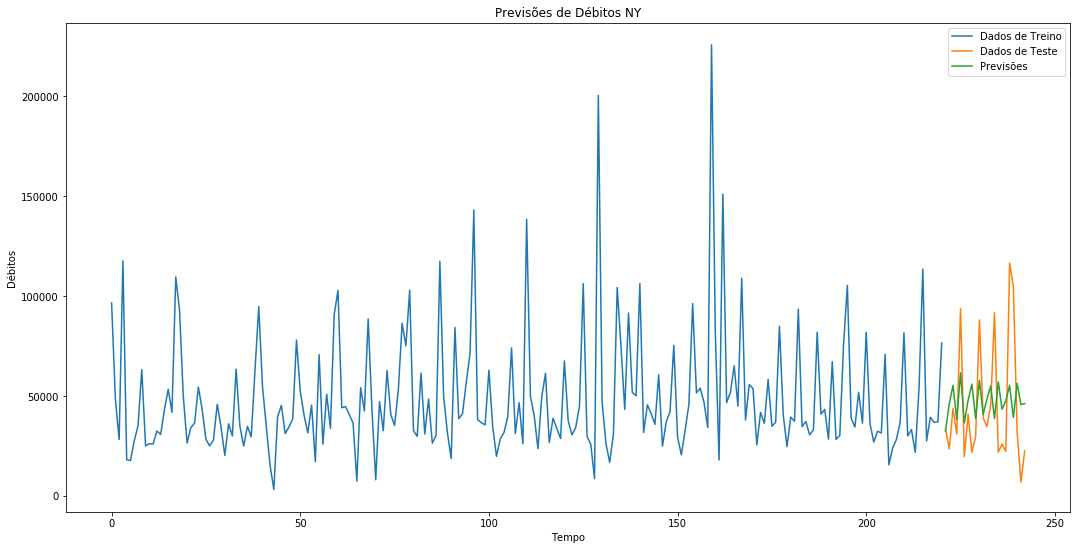

In [55]:
# Modelo de série temporal
modelo_v3 = SARIMAX(dados_treino['TOT DBTS (0)'], order = (9, 2, 3), seasonal_order = (0, 0, 0, 0))

# Treinamento do modelo
resultado = modelo_v3.fit()

# Vamos fazer a previsão dos próximos 10 dias
forecast = resultado.forecast(22)

# Plot
plt.figure(figsize = (18,9))
plt.plot(dados_treino['TOT DBTS (0)'], label = 'Dados de Treino')
plt.plot(dados_teste['TOT DBTS (0)'], label = 'Dados de Teste')
plt.plot(forecast, label = 'Previsões')
plt.title('Previsões de Débitos NY')
plt.xlabel('Tempo')
plt.ylabel('Débitos')
plt.legend()

In [56]:
# Calcula o erro
rms = np.sqrt(mean_squared_error(dados_teste['TOT DBTS (0)'], forecast))
print("RMSE : ", rms)

RMSE :  30274.81363650295


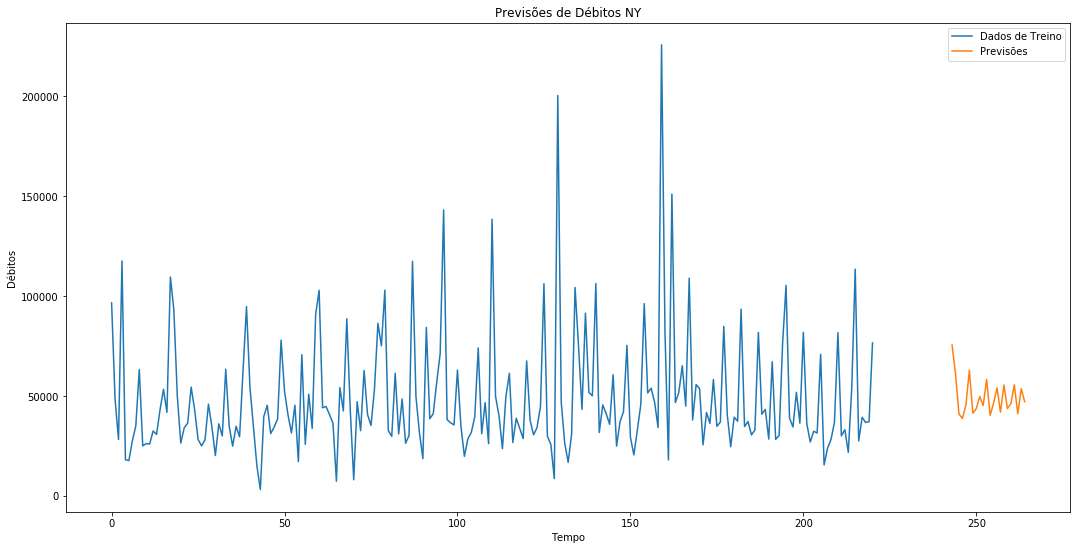

In [57]:
# Modelo de série temporal
modelo_v3 = SARIMAX(df['TOT DBTS (0)'], order = (9, 2, 3), seasonal_order = (0, 0, 0, 0))

# Treinamento do modelo
resultado = modelo_v3.fit()

# Vamos fazer a previsão dos próximos 10 dias
forecast = resultado.forecast(22)

# Plot
plt.figure(figsize = (18,9))
plt.plot(dados_treino['TOT DBTS (0)'], label = 'Dados de Treino')
plt.plot(forecast, label = 'Previsões')
plt.title('Previsões de Débitos NY')
plt.xlabel('Tempo')
plt.ylabel('Débitos')
plt.legend()

In [58]:
forecast

243    75446.800037
244    60968.318415
245    40906.018792
246    38711.501850
247    45494.321313
248    62819.830146
249    41340.683539
250    43619.456061
251    49642.056678
252    45205.417021
253    58238.843051
254    40300.984843
255    46344.483160
256    54058.980090
257    41863.103334
258    55485.002194
259    43682.029227
260    46148.091413
261    55554.907498
262    41055.748324
263    53620.442076
264    47156.363650
Name: predicted_mean, dtype: float64

# Versão Final

In [59]:
# Carregando os Dados originais
df = pd.read_excel('Dados_final.xlsx', sheet_name='Planilha1')
df.describe()

,TOT DBTS (0)
count,255.000000
mean,48448.026358
std,30388.431816
min,3136.200000
25%,29980.770000
50%,38511.270000
75%,54378.165000
max,225701.710000


In [60]:
# Modelo de série temporal
modelo_v3 = SARIMAX(df['TOT DBTS (0)'], order = (9, 2, 3), seasonal_order = (0, 0, 0, 0))

# Treinamento do modelo
resultado = modelo_v3.fit()

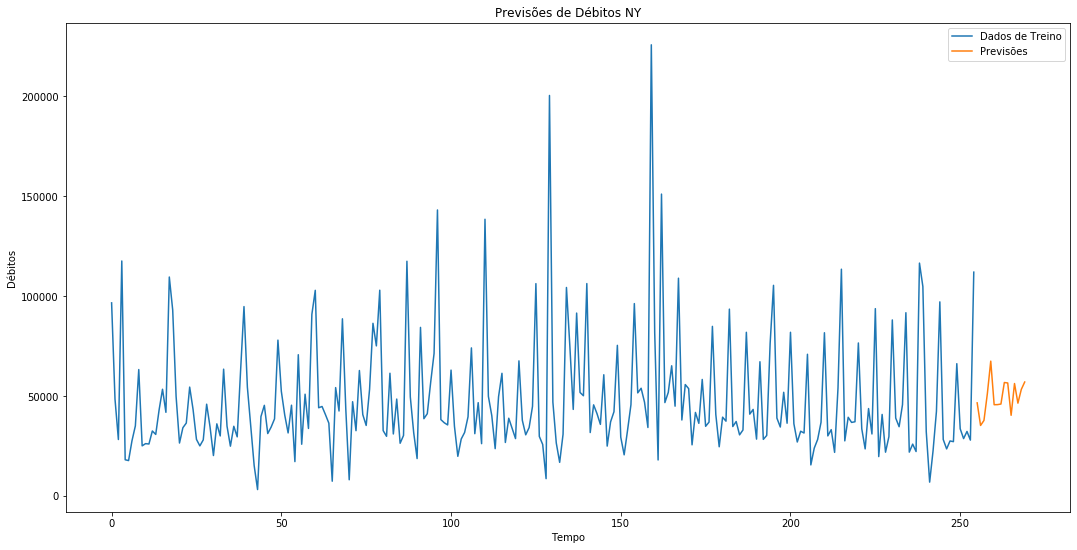

In [61]:
# Vamos fazer a previsão dos próximos 15 dias
forecast = resultado.forecast(15)

# Plot
plt.figure(figsize = (18,9))
plt.plot(df['TOT DBTS (0)'], label = 'Dados de Treino')
plt.plot(forecast, label = 'Previsões')
plt.title('Previsões de Débitos NY')
plt.xlabel('Tempo')
plt.ylabel('Débitos')
plt.legend()

In [ ]:
forecast = resultado.forecast(60)
saldo = 1519816.53
i = 0

while saldo > 700000:
    saldo = saldo - list(forecast)[i]
    i = i + 1
    print("Saldo atual da conta é de: {}, o valor previsto para debitar a conta é de: {}".format(round(saldo,2), round(list(forecast)[i],2)))
    
print("Sera necessario uma nova remessa em: {} dias".format(i))